# Estudio comparativo de algoritmos en un problema de k-armed bandit

*Description:* El experimento compara el rendimiento de algoritmos epsilon-greedy en un problema de k-armed bandit.
Se generan gráficas de recompensas promedio para cada algoritmo.

    Author: Luis Daniel Hernández Molinero
    Email: ldaniel@um.es
    Date: 2025/01/29

This software is licensed under the GNU General Public License v3.0 (GPL-3.0),
with the additional restriction that it may not be used for commercial purposes.

For more details about GPL-3.0: https://www.gnu.org/licenses/gpl-3.0.html



## Preparación del entorno


In [1]:
#@title Copiar el repositorio.

!git clone https://github.com/ldaniel-hm/eml_k_bandit.git
!cd eml_k_bandit/

Cloning into 'eml_k_bandit'...


In [2]:
#@title Importamos todas las clases y funciones

import sys

# Añadir los directorio fuentes al path de Python
sys.path.append('/content/eml_k_bandit')


# Verificar que se han añadido correctamente
print(sys.path)

import numpy as np
from typing import List

from algorithms import Algorithm, EpsilonGreedy
from arms import ArmNormal, ArmBeta, ArmBernoulli, ArmBinomial, Bandit
from plotting import plot_average_rewards, plot_optimal_selections, plot_arm_statistics, plot_regret

['c:\\Users\\Usuario\\AppData\\Local\\Programs\\Python\\Python312\\python312.zip', 'c:\\Users\\Usuario\\AppData\\Local\\Programs\\Python\\Python312\\DLLs', 'c:\\Users\\Usuario\\AppData\\Local\\Programs\\Python\\Python312\\Lib', 'c:\\Users\\Usuario\\AppData\\Local\\Programs\\Python\\Python312', '', 'C:\\Users\\Usuario\\AppData\\Roaming\\Python\\Python312\\site-packages', 'C:\\Users\\Usuario\\AppData\\Roaming\\Python\\Python312\\site-packages\\win32', 'C:\\Users\\Usuario\\AppData\\Roaming\\Python\\Python312\\site-packages\\win32\\lib', 'C:\\Users\\Usuario\\AppData\\Roaming\\Python\\Python312\\site-packages\\Pythonwin', 'c:\\Users\\Usuario\\AppData\\Local\\Programs\\Python\\Python312\\Lib\\site-packages', '/content/eml_k_bandit']


ModuleNotFoundError: No module named 'numpy'

## Experimento

Cada algoritmo se ejecuta en un problema de k-armed bandit durante un número de pasos de tiempo y ejecuciones determinado.
Se comparan los resultados de los algoritmos en términos de recompensa promedio.

Por ejemplo. Dado un bandido de k-brazos, se ejecutan dos algoritmos epsilon-greedy con diferentes valores de epsilon. Se estudia la evolución de cada política  en un número de pasos, por ejemplo, mil pasos. Entonces se repite el experimento un número de veces, por ejemplo, 500 veces. Es decir, se ejecutan 500 veces la evolución de cada algoritmo en 1000 pasos. Para cada paso calculamos el promedio de las recoponensas obtenidas en esas 500 veces.

In [ ]:

def run_experiment(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):

    optimal_arm = bandit.optimal_arm  # Necesario para calcular el porcentaje de selecciones óptimas.

    rewards = np.zeros((len(algorithms), steps)) # Matriz para almacenar las recompensas promedio.

    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para almacenar el porcentaje de selecciones óptimas.

    regret = np.zeros((len(algorithms), steps))  # Matriz para almacenar el regret.


    arm_stats = [
        [{"arm": i + 1, "promedy_rewards": 0.0, "times_pulled": 0, "optimal": i==optimal_arm} for i in range(bandit.k)]
        for _ in range(len(algorithms))
        ]


    np.random.seed(seed)  # Asegurar reproducibilidad de resultados.



    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms)

        for algo in algorithms:
            algo.reset() # Reiniciar los valores de los algoritmos.

        total_rewards_per_algo = np.zeros(len(algorithms)) # Acumulador de recompensas por algoritmo. Necesario para calcular el promedio.

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm() # Seleccionar un brazo según la política del algoritmo.
                reward = current_bandit.pull_arm(chosen_arm) # Obtener la recompensa del brazo seleccionado.
                algo.update(chosen_arm, reward) # Actualizar el valor estimado del brazo seleccionado.

                rewards[idx, step] += reward # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                total_rewards_per_algo[idx] += reward # Acumular la recompensa obtenida en total_rewards_per_algo para el algoritmo idx.

                regret[idx, step] += current_bandit.get_expected_value(optimal_arm) - current_bandit.get_expected_value(chosen_arm)

                #TODO: modificar optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm
                optimal_selections[idx, step] += (chosen_arm == optimal_arm)
                arm_stats[idx][chosen_arm]["times_pulled"] += 1
                arm_stats[idx][chosen_arm]["promedy_rewards"] += reward



    rewards /= runs
    regret /= runs
    for algo_idx in range(len(algorithms)):
        for arm_idx in range(bandit.k):
            if arm_stats[algo_idx][arm_idx]["times_pulled"] == 0:
                arm_stats[algo_idx][arm_idx]["promedy_rewards"] = 0.0
            else:
                arm_stats[algo_idx][arm_idx]["promedy_rewards"] /= arm_stats[algo_idx][arm_idx]["times_pulled"]
                arm_stats[algo_idx][arm_idx]["promedy_rewards"] = np.round(arm_stats[algo_idx][arm_idx]["promedy_rewards"], 2)
            arm_stats[algo_idx][arm_idx]["times_pulled"] /= runs
            arm_stats[algo_idx][arm_idx]["times_pulled"] = round(arm_stats[algo_idx][arm_idx]["times_pulled"])
    # TODO: calcular el porcentaje de selecciones óptimas y almacenar en optimal_selections

    optimal_selections /= runs

    return rewards, optimal_selections, arm_stats, regret


In [ ]:

def run_experiment_beta(bandit: Bandit, algorithms: List[Algorithm], steps: int, runs: int):

    optimal_arm = bandit.optimal_arm  # Necesario para calcular el porcentaje de selecciones óptimas.

    rewards = np.zeros((len(algorithms), steps)) # Matriz para almacenar las recompensas promedio.

    optimal_selections = np.zeros((len(algorithms), steps))  # Matriz para almacenar el porcentaje de selecciones óptimas.

    regret = np.zeros((len(algorithms), steps))  # Matriz para almacenar el regret.


    arm_stats = [
        [{"arm": i + 1, "promedy_rewards": 0.0, "times_pulled": 0, "optimal": i==optimal_arm} for i in range(bandit.k)]
        for _ in range(len(algorithms))
        ]


    np.random.seed(seed)  # Asegurar reproducibilidad de resultados.

    for run in range(runs):
        current_bandit = Bandit(arms=bandit.arms)

        for algo in algorithms:
            algo.reset() # Reiniciar los valores de los algoritmos.

        total_rewards_per_algo = np.zeros(len(algorithms)) # Acumulador de recompensas por algoritmo. Necesario para calcular el promedio.

        for step in range(steps):
            for idx, algo in enumerate(algorithms):
                chosen_arm = algo.select_arm() # Seleccionar un brazo según la política del algoritmo.
                reward = current_bandit.pull_arm(chosen_arm) # Obtener la recompensa del brazo seleccionado.
                algo.update(chosen_arm, reward) # Actualizar el valor estimado del brazo seleccionado.
                if reward > 2.0:
                  bandit.arms[chosen_arm].update(success=1)
                else:
                  bandit.arms[chosen_arm].update(success=0)





                rewards[idx, step] += reward # Acumular la recompensa obtenida en la matriz rewards para el algoritmo idx en el paso step.
                total_rewards_per_algo[idx] += reward # Acumular la recompensa obtenida en total_rewards_per_algo para el algoritmo idx.

                regret[idx, step] += current_bandit.get_expected_value(optimal_arm) - current_bandit.get_expected_value(chosen_arm)

                #TODO: modificar optimal_selections cuando el brazo elegido se corresponda con el brazo óptimo optimal_arm
                optimal_selections[idx, step] += (chosen_arm == optimal_arm)
                arm_stats[idx][chosen_arm]["times_pulled"] += 1
                arm_stats[idx][chosen_arm]["promedy_rewards"] += reward



    rewards /= runs
    regret /= runs
    for algo_idx in range(len(algorithms)):
        for arm_idx in range(bandit.k):
            if arm_stats[algo_idx][arm_idx]["times_pulled"] == 0:
                arm_stats[algo_idx][arm_idx]["promedy_rewards"] = 0.0
            else:
                arm_stats[algo_idx][arm_idx]["promedy_rewards"] /= arm_stats[algo_idx][arm_idx]["times_pulled"]
                arm_stats[algo_idx][arm_idx]["promedy_rewards"] = np.round(arm_stats[algo_idx][arm_idx]["promedy_rewards"], 2)
            arm_stats[algo_idx][arm_idx]["times_pulled"] /= runs
            arm_stats[algo_idx][arm_idx]["times_pulled"] = round(arm_stats[algo_idx][arm_idx]["times_pulled"])
    # TODO: calcular el porcentaje de selecciones óptimas y almacenar en optimal_selections

    optimal_selections /= runs

    return rewards, optimal_selections, arm_stats, regret


## Ejecución del experimento

Se realiza el experimento usando 10 brazos, cada uno de acuerdo a una distribución gaussina con desviación 1. Se realizan 500 ejecuciones de 1000 pasos cada una. Se contrastan 3 algoritmos epsilon greedy para valores epsilon: 0.0, 0.01, y 0.1.

In [ ]:

# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmNormal.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
algorithms = [EpsilonGreedy(k=k, epsilon=0), EpsilonGreedy(k=k, epsilon=0.01), EpsilonGreedy(k=k, epsilon=0.1)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, arm_stats, regret_accumulated = run_experiment(bandit, algorithms, steps, runs)


Bandit with 10 arms: ArmNormal(mu=1.52, sigma=1.0), ArmNormal(mu=2.4, sigma=1.0), ArmNormal(mu=1.19, sigma=1.0), ArmNormal(mu=4.37, sigma=1.0), ArmNormal(mu=6.39, sigma=1.0), ArmNormal(mu=7.59, sigma=1.0), ArmNormal(mu=8.8, sigma=1.0), ArmNormal(mu=9.56, sigma=1.0), ArmNormal(mu=6.41, sigma=1.0), ArmNormal(mu=7.37, sigma=1.0)
Optimal arm: 8 with expected reward=9.56


## Visualización de los resultados

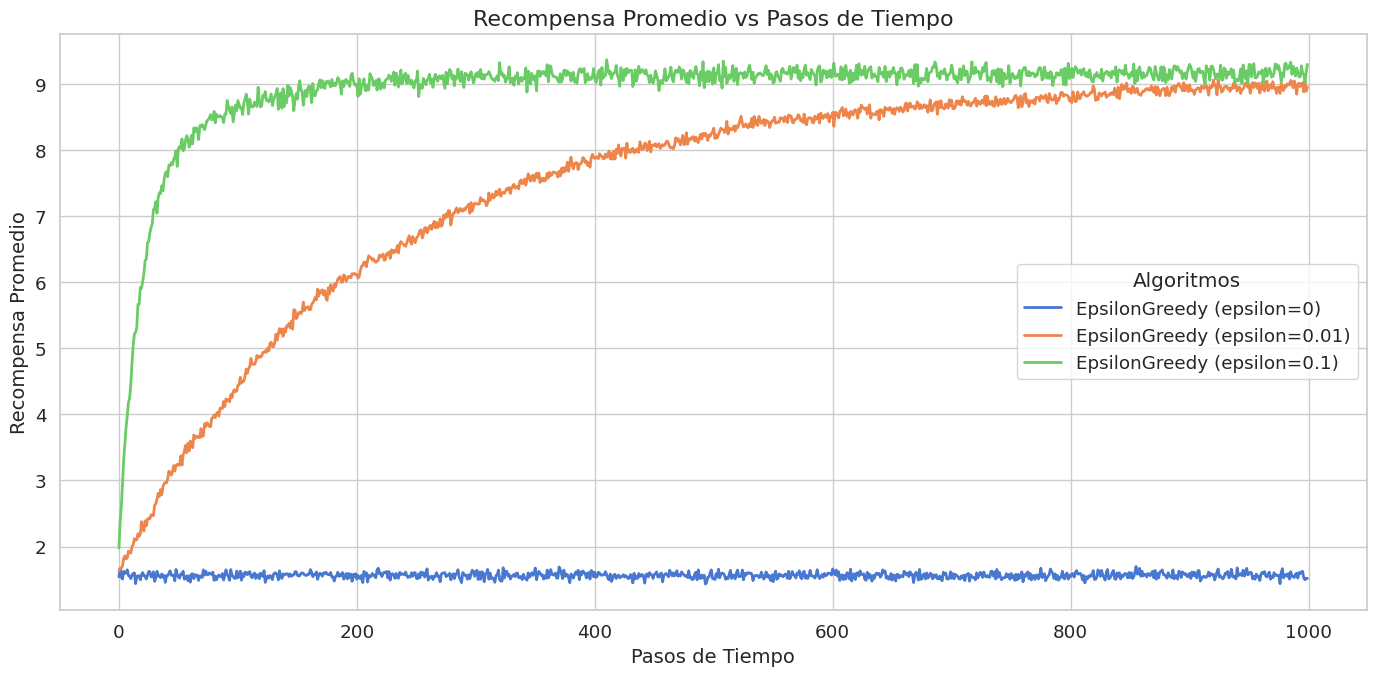

In [ ]:

# Graficar los resultados
plot_average_rewards(steps, rewards, algorithms)
# plot_optimal_selections(steps, optimal_selections, algorithms)


### Análisis detallado de **"Recompensa Promedio vs Pasos de Tiempo"**
La imagen muestra un gráfico de líneas titulado **"Recompensa Promedio vs Pasos de Tiempo"**, donde se analiza el desempeño de diferentes estrategias del algoritmo **ε-Greedy** en un entorno de multi-armed bandit. En el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra la **recompensa promedio** obtenida por cada algoritmo.


1. **Tres líneas de colores distintos representan diferentes valores de ε en el algoritmo ε-Greedy:**
   - **Azul (ε = 0):** Representa una estrategia completamente **explotadora**, es decir, que siempre elige la acción que ha dado la mejor recompensa hasta ahora sin explorar nuevas opciones.
   - **Naranja (ε = 0.01):** Representa una estrategia con una pequeña probabilidad del 1% de elegir una acción aleatoria (exploración). Esto ayudará a no explotar un mismo brazo y buscar más brazos que puedan maximizar la recompensa.
   - **Verde (ε = 0.1):** Representa una estrategia con un 10% de probabilidad de explorar acciones aleatorias.

2. **Crecimiento de la recompensa promedio:**
   - La línea **verde (ε=0.1)** alcanza rápidamente una recompensa promedio alta, lo que indica que la estrategia con mayor exploración aprende más rápido qué brazos del bandit son óptimos.
   - La línea **naranja (ε=0.01)** también muestra un crecimiento, pero más lento en comparación con ε=0.1.
   - La línea **azul (ε=0)** se mantiene en un nivel bajo de recompensa, lo que sugiere que no logra encontrar el mejor brazo porque no explora nuevas opciones.

---





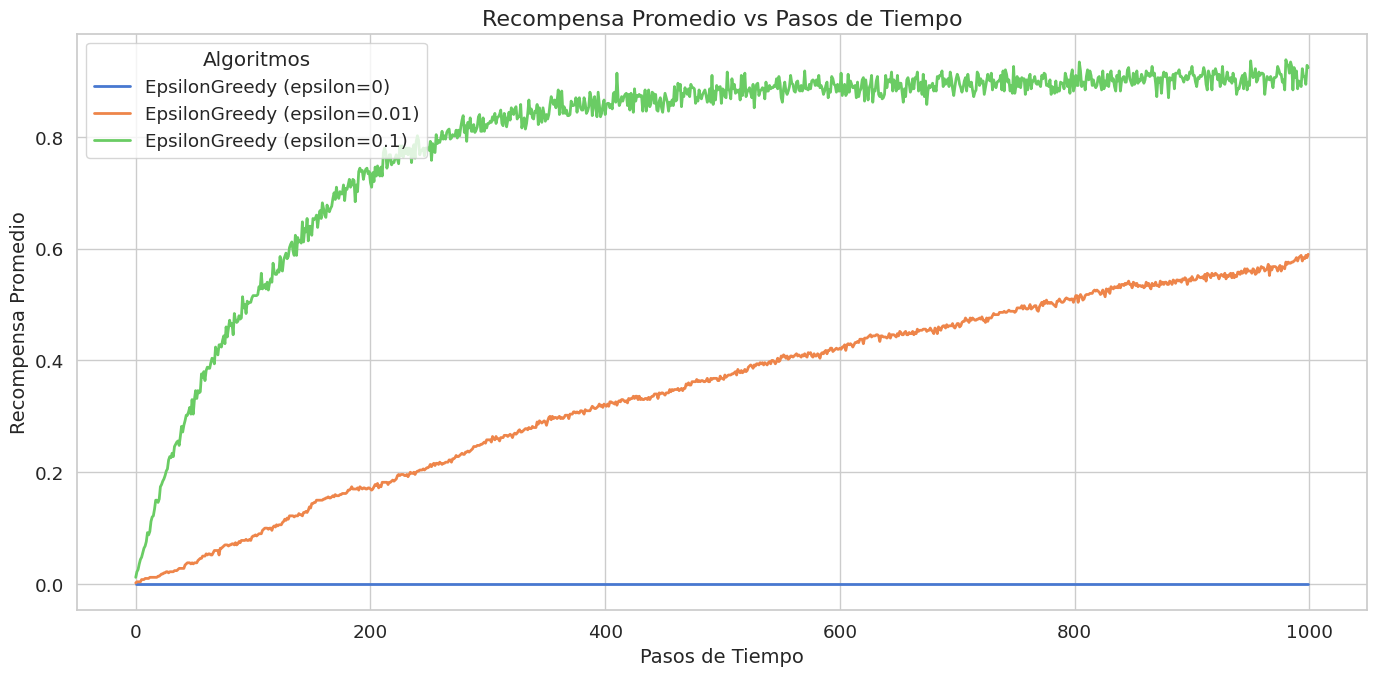

In [ ]:
plot_optimal_selections(steps, optimal_selections, algorithms)

### Análisis detallado de **"Selección del Brazo Óptimo vs Pasos de Tiempo"**

La imagen muestra un gráfico de líneas titulado **"Selección del Brazo Óptimo vs Pasos de Tiempo"**, donde se analiza el número de veces promedio que se elige el brazo óptimo **ε-Greedy** en un entorno de multi-armed bandit. En el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el promedio de **selecciones del brazo óptimo** obtenida por cada algoritmo.


1. **Tres líneas de colores distintos representan diferentes valores de ε en el algoritmo ε-Greedy:**
   - **Azul (ε = 0):** Representa una estrategia completamente **explotadora**, es decir, que siempre elige la acción que ha dado la mejor recompensa hasta ahora sin explorar nuevas opciones. Por lo que será complicado que esta estrategia elija el brazo óptimo a no ser que lo elija en una primera instancia.
   - **Naranja (ε = 0.01):** Representa una estrategia con una pequeña probabilidad del 1% de elegir una acción aleatoria (exploración). Esto ayudará a no solo realizar explotación, sino también realizar exploración para encontrar el brazo óptimo.
   - **Verde (ε = 0.1):** Representa una estrategia con un 10% de probabilidad de explorar acciones aleatorias.

2. **Selección del brazo óptimo:**
   - La línea **verde (ε=0.1)** alcanza rápidamente el brazo óptimo lo que indica que la estrategia con mayor exploración aprende más rápido qué brazos del bandit son óptimos.
   - La línea **naranja (ε=0.01)** también muestra un crecimiento, pero más lento en comparación con ε=0.1. Por lo que tardaría algo más en encontrar el brazo óptimo pero también lo encontraría.
   - La línea **azul (ε=0)** al no tener exploración no logra encontrar el mejor brazo porque no explora nuevas opciones.

---

/content/eml_k_bandit/plotting/plotting.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=45, ha="right", fontsize=10)


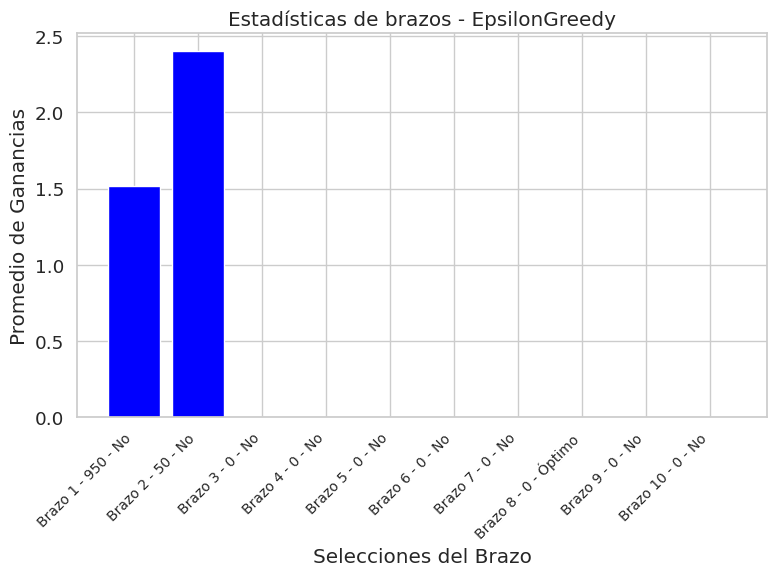

/content/eml_k_bandit/plotting/plotting.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=45, ha="right", fontsize=10)


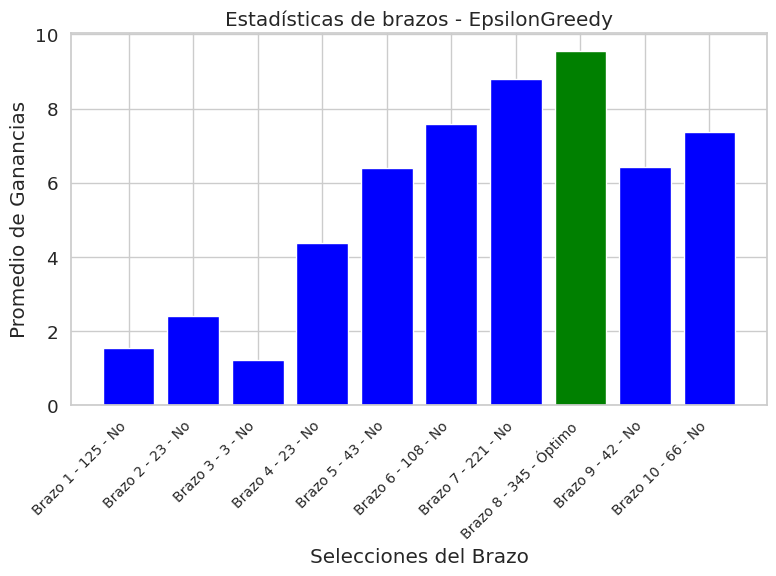

/content/eml_k_bandit/plotting/plotting.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=45, ha="right", fontsize=10)


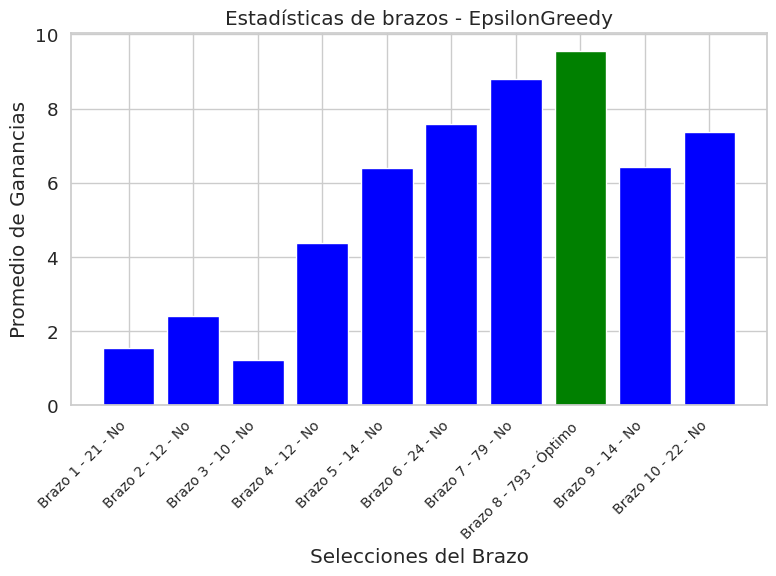

In [ ]:
plot_arm_statistics(arm_stats, algorithms)

### Análisis detallado de **"Estadísticas de los brazos"**

Las imágenes muestran un histograma donde podremos ver las estadísticas de los brazos, donde se analiza las estadísticas de los brazos en los algoritmos **ε-Greedy** en un entorno de multi-armed bandit. Algunas de las estadísticas que veremos serán la recompensa promedio, cuantas veces ha sido elegido cada brazo, si es el brazo óptimo y el número del brazo.


1. **Tres Histogramas que muestran las diferencias de valores de ε en el algoritmo ε-Greedy:**
   - La primera gráfica muestra las estadísticas de los brazos para el algoritmo ε-Greedy con ε = 0, por lo que no tendrá ningún componente de exploración.
   - La segunda nos muestra las estadísticas de los brazos para el algoritmo ε-Greedy con ε = 0.01, por lo que tendrá un 1% de probabilidad de exploración.
   - La tercera nos muestra las estadísticas de los brazos para el algoritmo ε-Greedy con ε = 0.1, por lo que tendrá un 10% de probabilidad de exploración, haciendo así que haya un mayor componente de exploración.

2. **Estadísticas brazos**
   - En el primer histograma podemos ver el cómo el algoritmo a no tener exploración siempre se quedara en su primera opción elegida ya es que la mejor recompensa le ha dado hasta el momento. Entre ejecuciones podemos ver como elige entre el brazo 1 o el 2, aunque suele elegir el brazo 1 y ninguno de los 2 es el brazo óptimo. Además podemos ver como de media en las tiradas que sale parece que el brazo 2 da una mejor recompensa promedio.
   - En el segundo histograma ya podemos apreciar la exploración y el cómo se eligen una mayor cantidad de brazos y no se centra en solo explotar uno, podemos darnos cuenta de que alcanza el brazo óptimo que le otorga la mayor recompensa promedio y además es el brazo que una vez encontrado más veces se tiende a elegir dado que es el que mayor recompensa ha dado
   - Ocurre un comportamiento similar al anterior, pero al tener un mayor porcentaje de exploración alcanza antes el brazo óptimo lo que hace que ya lo pueda elegir o explotar más veces al saber que es el brazo con la mayor recompensa que le ha dado.

---

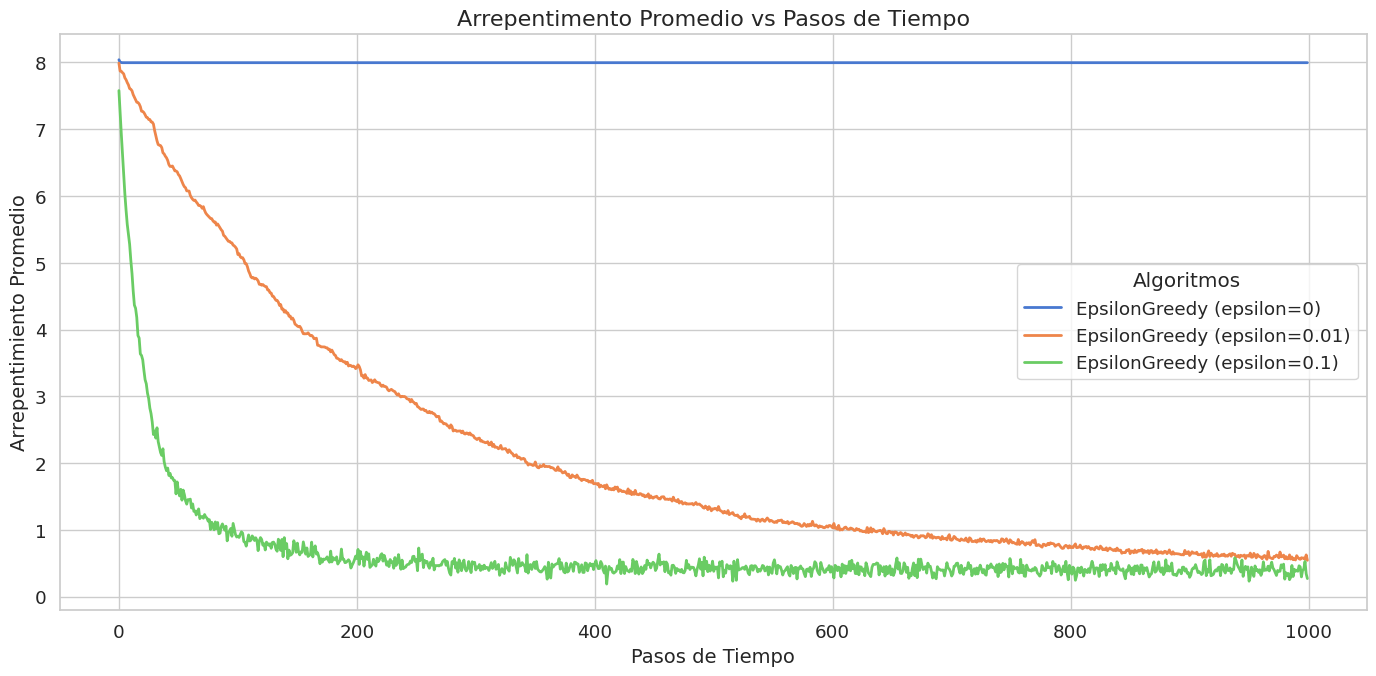

In [ ]:
plot_regret(steps, regret_accumulated, algorithms)

### Análisis detallado de **"Arrepentimiento Promedio vs Pasos de Tiempo"**

La imagen muestra un gráfico de líneas titulado **"Arrepentimiento promedio vs Pasos de Tiempo"**, donde se analiza el arrepentimiento promedio de las estrategias del algoritmo **ε-Greedy** en un entorno de multi-armed bandit. En el eje **x** se representan los **pasos de tiempo**, mientras que en el eje **y** se muestra el **arrepentimiento promedio** obtenida por cada algoritmo.


1. **Tres líneas de colores distintos representan diferentes valores de ε en el algoritmo ε-Greedy:**
   - **Azul (ε = 0):** Representa una estrategia completamente **explotadora**, es decir, que siempre elige la acción que ha dado la mejor recompensa hasta ahora sin explorar nuevas opciones. Por lo que esta estrategia difícilmente podría elegir el brazo óptimo a no ser que lo elija de primeras, lo que hará que el arrepentimiento aumente en este algoritmo.
   - **Naranja (ε = 0.01):** Representa una estrategia con una pequeña probabilidad del 1% de elegir una acción aleatoria (exploración).
   - **Verde (ε = 0.1):** Representa una estrategia con un 10% de probabilidad de explorar acciones aleatorias.

2. **Arrepentimiento promedio:**
   - La línea **verde (ε=0.1)** alcanza rápidamente el brazo óptimo lo que indica que la estrategia con mayor exploración aprende más rápido qué brazos del bandit son óptimos. Esto trae como resultado que rápidamente encuentre el brazo óptimo y por ende siempre este obteniendo la mejor recompensa, haciendo así que su arrepentimiento decrezca rápidamente hasta estandarizarse en valores mínimo
   - La línea **naranja (ε=0.01)** también muestra un decrecimiento, pero más lento en comparación con ε=0.1. Esto se debe a que como necesita más tiempo para encontrar el brazo óptimo, pues tirara más veces de brazos que no sean óptimos al tener un menor porcentaje de exploración, haciendo así que aumente el arrepentimiento hasta encontrar el brazo óptimo donde el arrepentimiento comienza a decrecer.
   - La línea **azul (ε=0)** al no tener exploración no logra encontrar el mejor brazo porque no explora nuevas opciones. Por lo que se mantiene con un arrepentimiento alto y de manera constante al nunca alcanzar el brazo óptimo.

---

## Conclusiones Normal

Hemos estudiado un **experimento de toma de decisiones secuenciales**, modelado con un **Multi-Armed Bandit (MAB)**. Este problema es fundamental en el aprendizaje por refuerzo y la teoría de decisiones. La idea principal es que un agente debe aprender cuál es la mejor acción (brazo del bandit) a partir de la experiencia acumulada. Para este estudio nos hemos centrado solo en el estudio del algoritmo epsilon-greedy, llegando a las siguientes conclusiones a partir de los resultados obtenidos y la gráfica generada:

#### **1. Exploración vs Explotación**
El algoritmo **ε-Greedy** equilibra la exploración y la explotación:
- **Explotación (ε=0)**: Siempre elige la mejor opción conocida, pero si inicialmente se selecciona un brazo subóptimo, nunca descubrirá otras opciones más rentables.
- **Exploración (ε>0)**: Introduce aleatoriedad en la selección de acciones para descubrir nuevas opciones potencialmente mejores.

Los gráficos confirman este comportamiento:
- **ε=0.1 (verde)** obtiene la mejor recompensa promedio a lo largo del tiempo porque explora lo suficiente como para encontrar rápidamente el mejor brazo y comenzar a explotarlo, además obtiene las mejores estadísticas y el arrepentimiento decrece rápidamente.
- **ε=0.01 (naranja)** explora menos, por lo que tarda más en converger a una recompensa alta y decrecer el arrepentimiento, aunque es cierto que encuentra el brazo óptimo, pero lo explota menos debido a que tarda más en encontrarlo.
- **ε=0 (azul)** no explora en absoluto y queda atrapado en una recompensa subóptima y un arrepentimiento estándar, además tiende a elegir siempre entre el brazo 1 o 2 y como no puede explorar solo se dedica a explotar el que haya elegido lo que le trae estos resultados.

#### **2. Convergencia de los algoritmos**
Los algoritmos con mayor exploración (ε=0.1) alcanzan una recompensa alta más rápido y un arrepentimiento bajo más rápido. Esto se debe a que:
- Al principio, el algoritmo **no tiene información suficiente** sobre cuál es el mejor brazo.
- Con el tiempo, al realizar exploraciones, descubre cuál es el mejor brazo y empieza a explotarlo más.
- Un **balance entre exploración y explotación** es clave para maximizar la recompensa a largo plazo.


#### **3. Aplicaciones y conclusiones**
- En problemas de toma de decisiones **(ejemplo: recomendaciones, optimización de anuncios, medicina personalizada)**, una estrategia de exploración moderada como **ε=0.1** es más efectiva para encontrar la mejor opción rápidamente.
- **La falta de exploración (ε=0)** lleva a un desempeño deficiente, ya que el agente puede quedarse atrapado en una elección subóptima.

En conclusión, **los gráficos muestran cómo un nivel adecuado de exploración mejora significativamente el rendimiento del algoritmo en un entorno de aprendizaje por refuerzo**. 🚀

## BINOMIAL

In [ ]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBinomial.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
algorithms = [EpsilonGreedy(k=k, epsilon=0), EpsilonGreedy(k=k, epsilon=0.01), EpsilonGreedy(k=k, epsilon=0.1)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, arm_stats, regret_accumulated = run_experiment(bandit, algorithms, steps, runs)

Bandit with 10 arms: ArmBinomial(probability=0.37, number=2), ArmBinomial(probability=0.95, number=2), ArmBinomial(probability=0.6, number=2), ArmBinomial(probability=0.73, number=2), ArmBinomial(probability=0.16, number=2), ArmBinomial(probability=0.06, number=2), ArmBinomial(probability=0.87, number=2), ArmBinomial(probability=0.71, number=2), ArmBinomial(probability=0.97, number=2), ArmBinomial(probability=0.02, number=2)
Optimal arm: 9 with expected reward=1.94


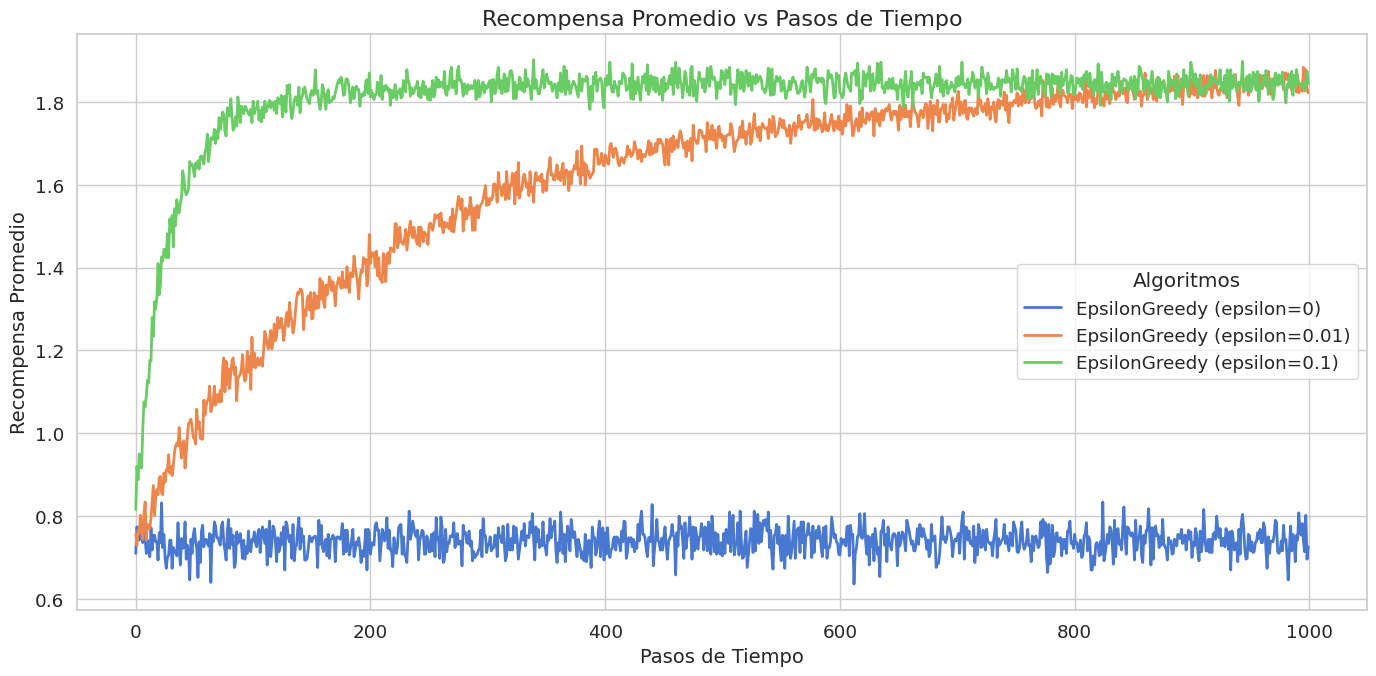

In [ ]:
plot_average_rewards(steps, rewards, algorithms)

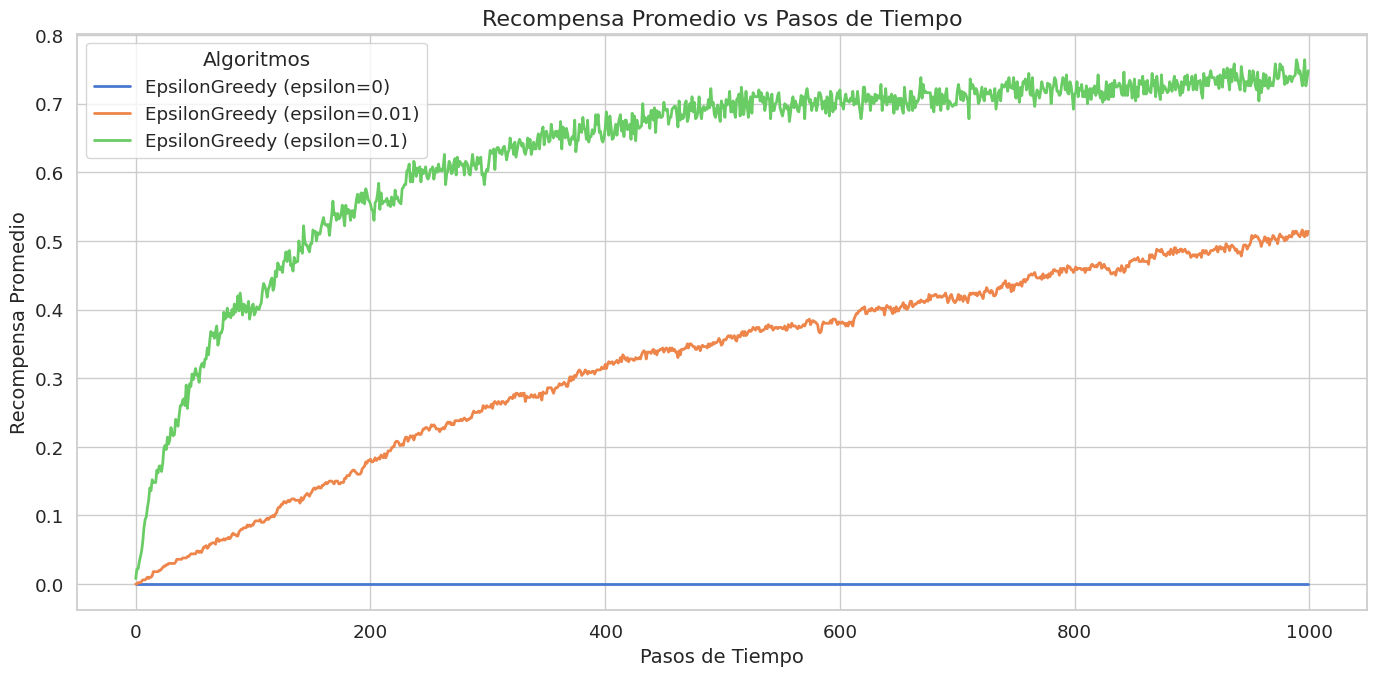

In [ ]:
plot_optimal_selections(steps, optimal_selections, algorithms)

/content/eml_k_bandit/plotting/plotting.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=45, ha="right", fontsize=10)


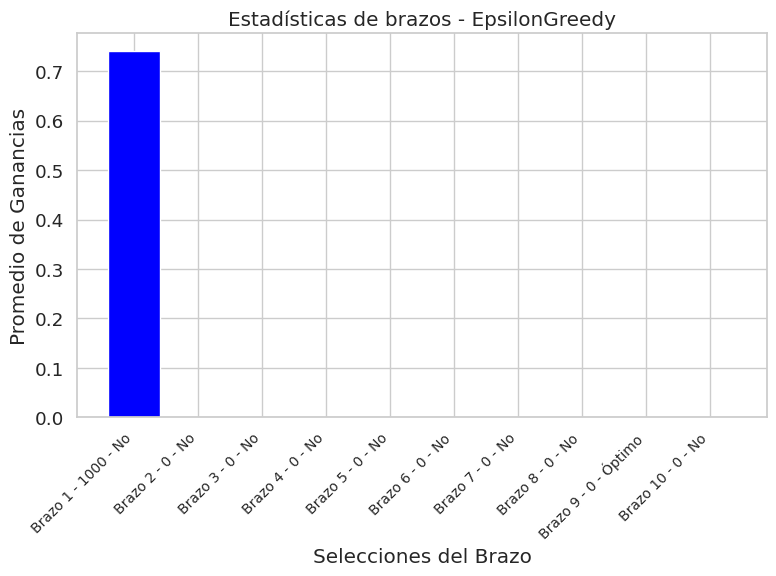

/content/eml_k_bandit/plotting/plotting.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=45, ha="right", fontsize=10)


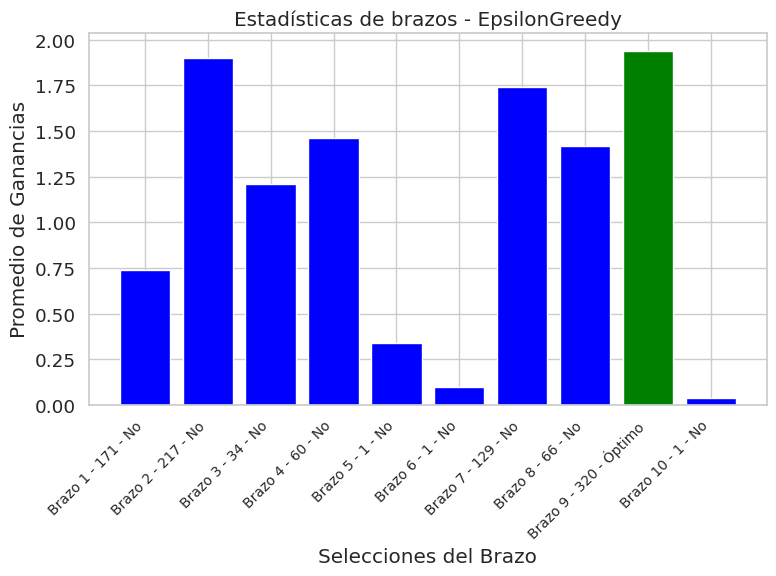

/content/eml_k_bandit/plotting/plotting.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=45, ha="right", fontsize=10)


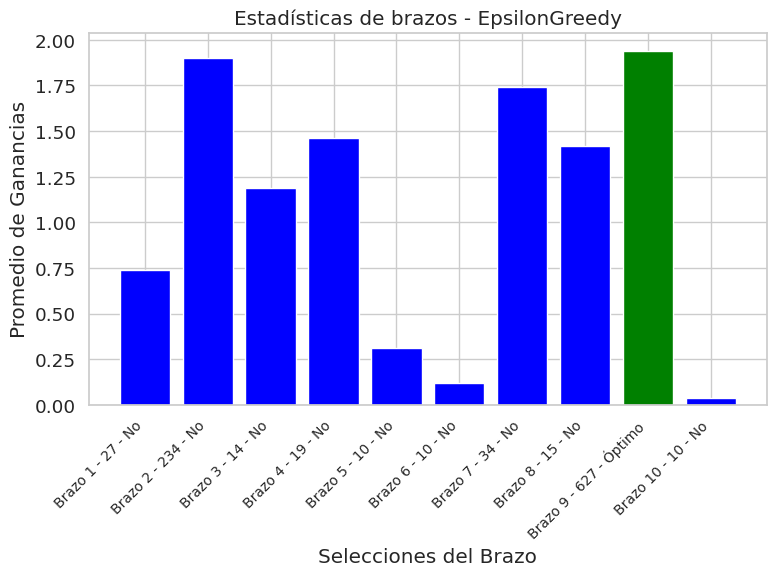

In [ ]:
plot_arm_statistics(arm_stats, algorithms)

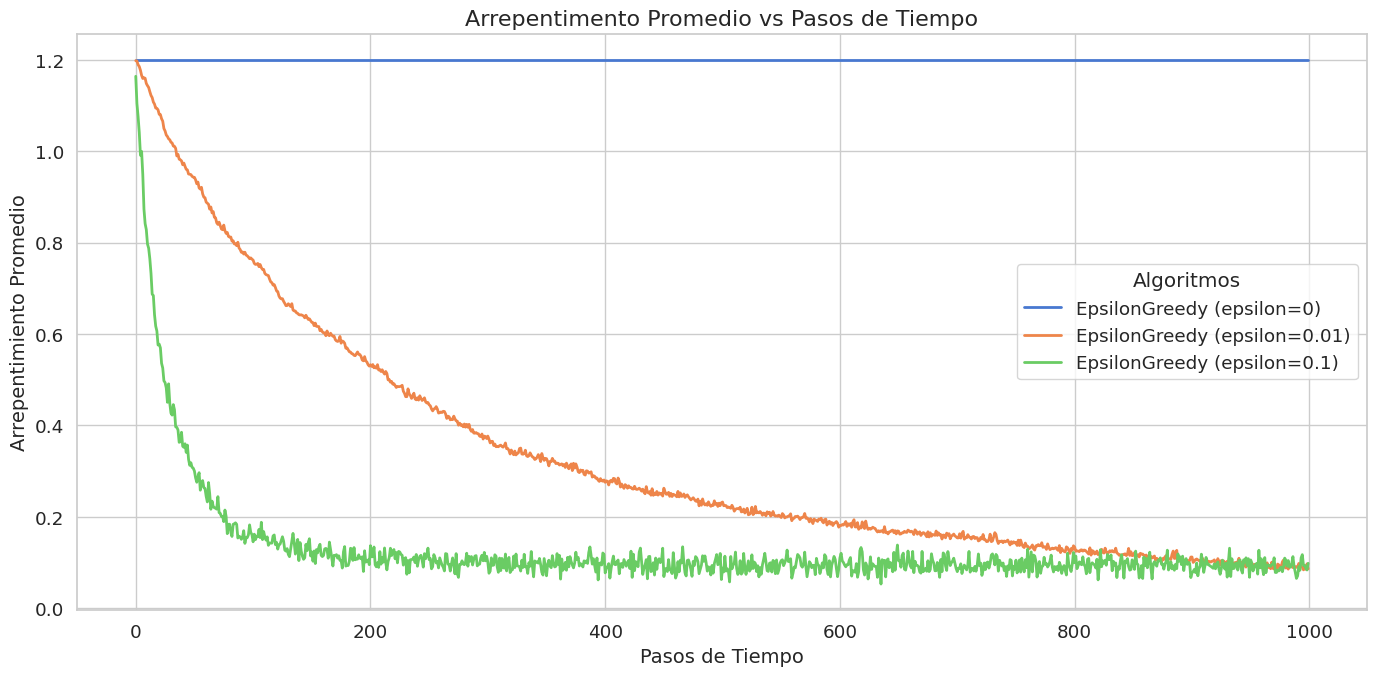

In [ ]:
plot_regret(steps, regret_accumulated, algorithms)

## BERNOULLI

In [ ]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBernoulli.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
algorithms = [EpsilonGreedy(k=k, epsilon=0), EpsilonGreedy(k=k, epsilon=0.01), EpsilonGreedy(k=k, epsilon=0.1)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, arm_stats, regret_accumulated = run_experiment(bandit, algorithms, steps, runs)

Bandit with 10 arms: ArmBenoulli(p=0.37), ArmBenoulli(p=0.95), ArmBenoulli(p=0.6), ArmBenoulli(p=0.73), ArmBenoulli(p=0.16), ArmBenoulli(p=0.06), ArmBenoulli(p=0.87), ArmBenoulli(p=0.71), ArmBenoulli(p=0.97), ArmBenoulli(p=0.02)
Optimal arm: 9 with expected reward=0.97


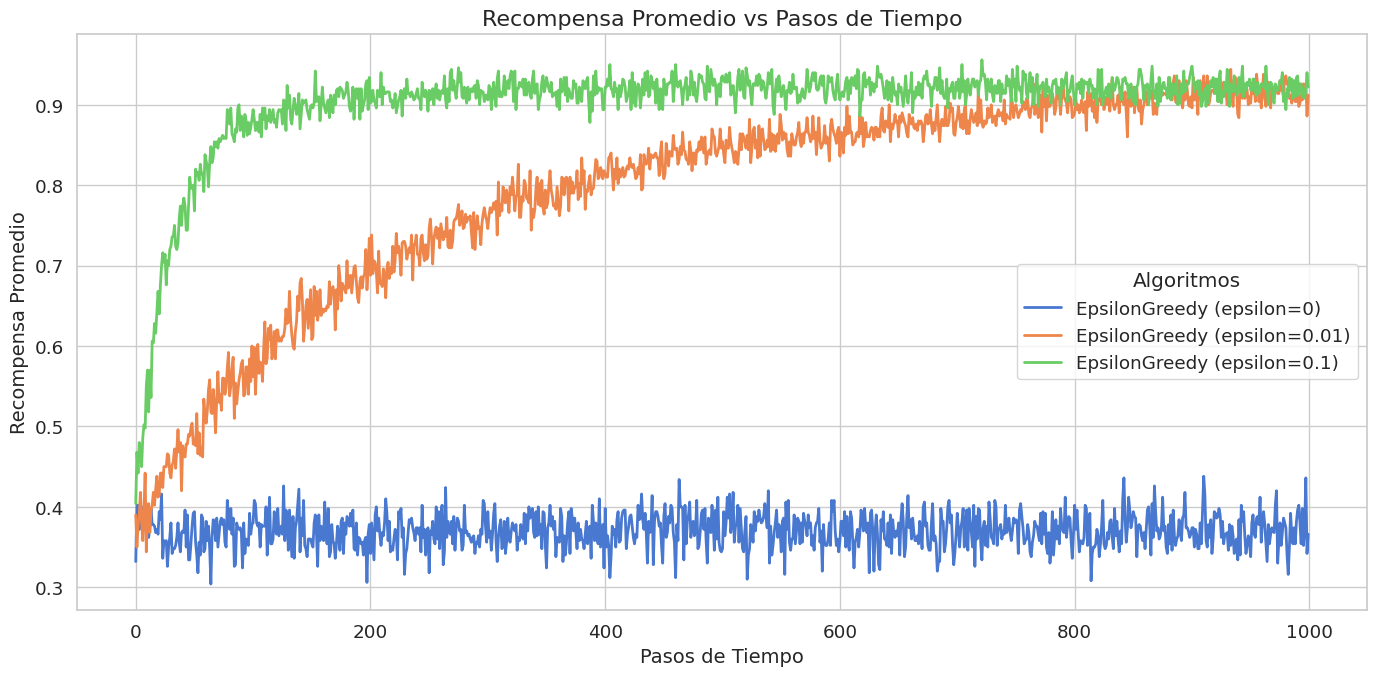

In [ ]:
plot_average_rewards(steps, rewards, algorithms)

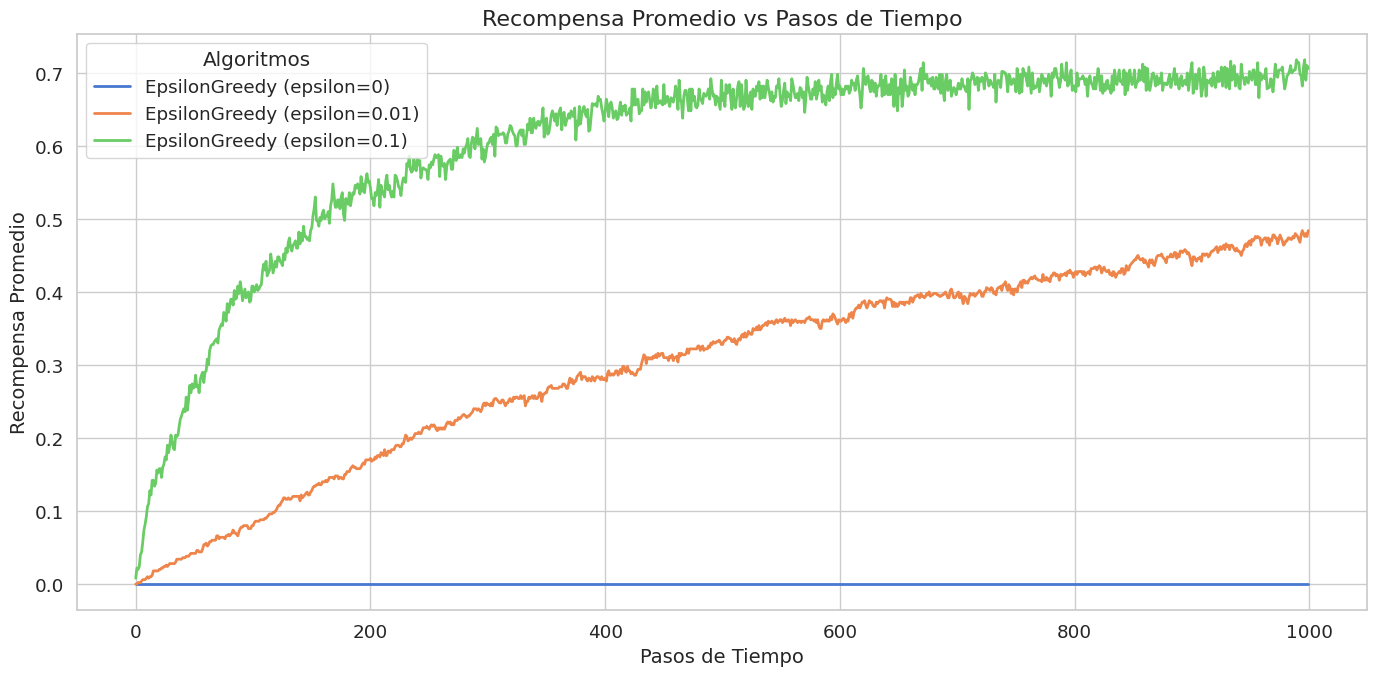

In [ ]:
plot_optimal_selections(steps, optimal_selections, algorithms)

/content/eml_k_bandit/plotting/plotting.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=45, ha="right", fontsize=10)


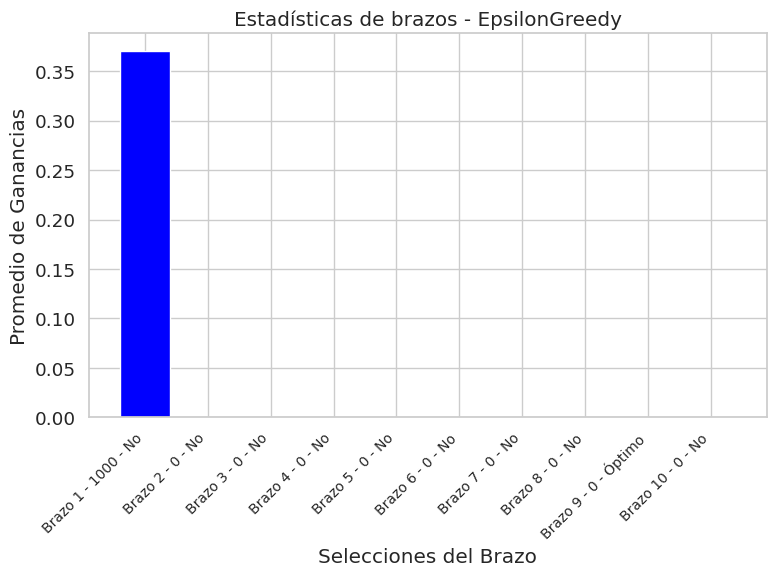

/content/eml_k_bandit/plotting/plotting.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=45, ha="right", fontsize=10)


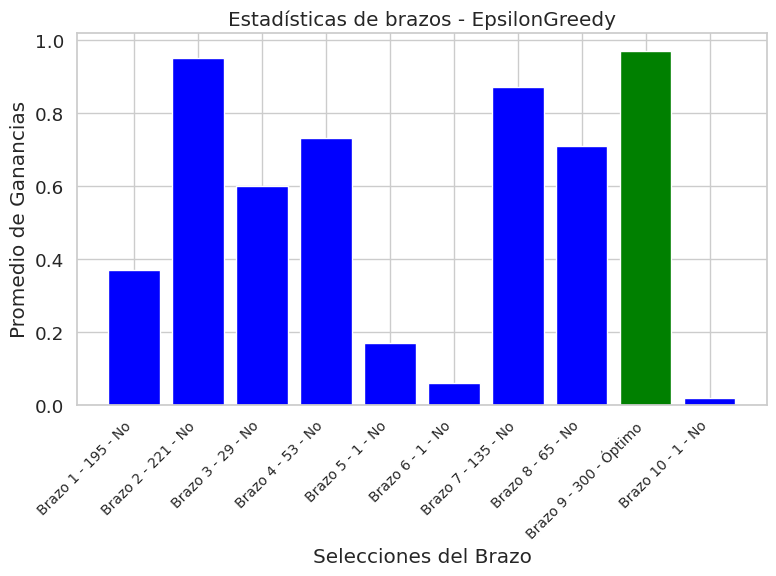

/content/eml_k_bandit/plotting/plotting.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=45, ha="right", fontsize=10)


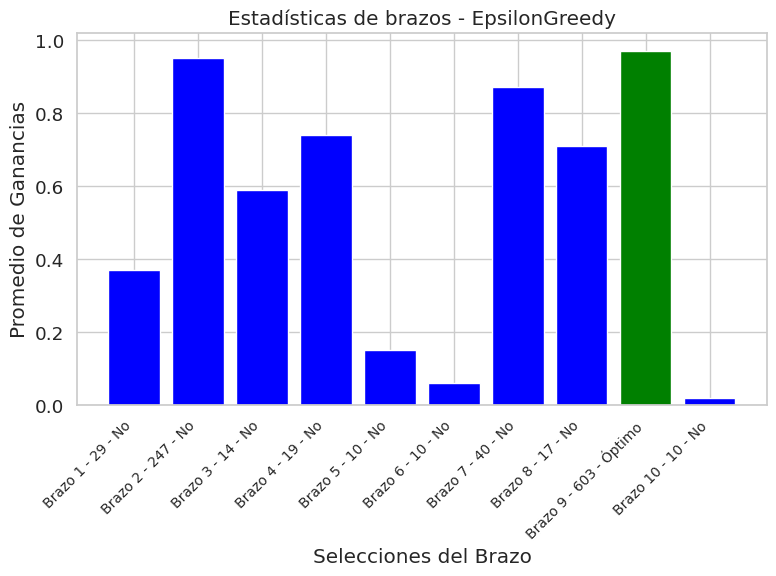

In [ ]:
plot_arm_statistics(arm_stats, algorithms)

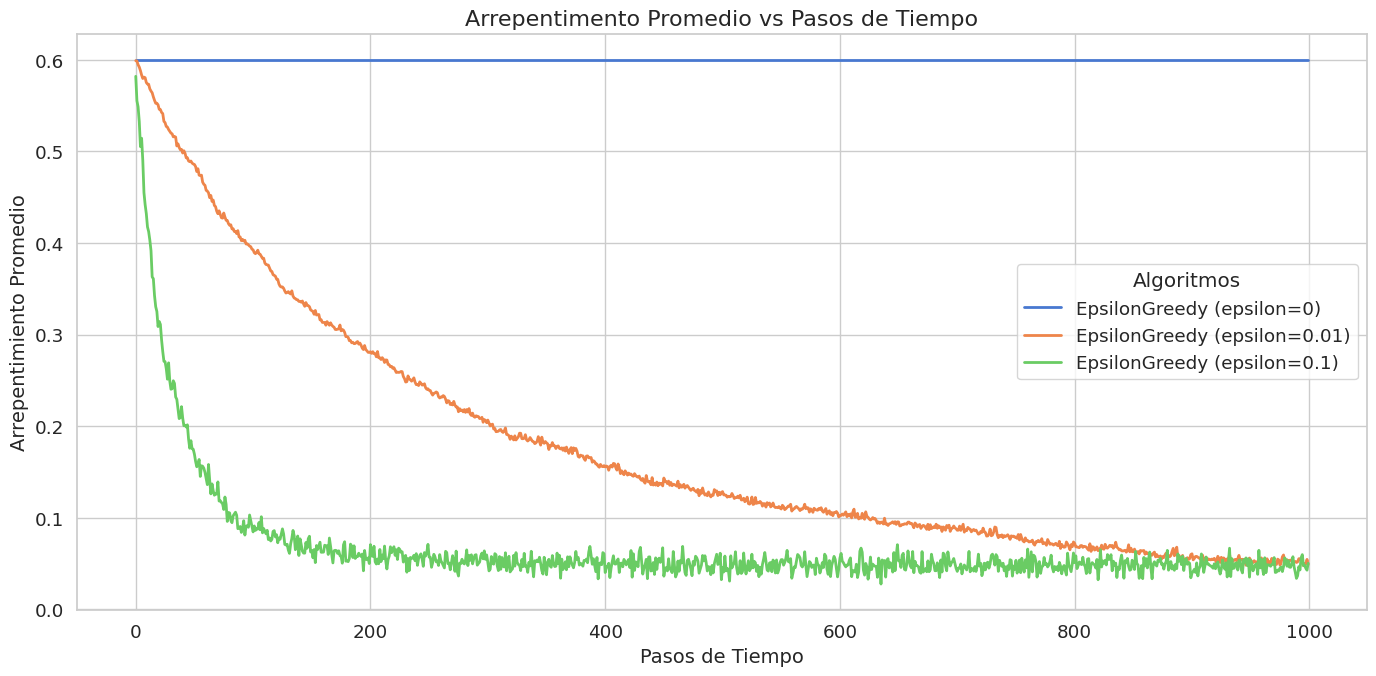

In [ ]:
plot_regret(steps, regret_accumulated, algorithms)

## BETA

In [ ]:
# Parámetros del experimento
seed = 42
np.random.seed(seed)  # Fijar la semilla para reproducibilidad

k = 10  # Número de brazos
steps = 1000  # Número de pasos que se ejecutarán cada algoritmo
runs = 500  # Número de ejecuciones

# Creación del bandit
bandit = Bandit(arms=ArmBeta.generate_arms(k)) # Generar un bandido con k brazos de distribución normal
print(bandit)

optimal_arm = bandit.optimal_arm
print(f"Optimal arm: {optimal_arm + 1} with expected reward={bandit.get_expected_value(optimal_arm)}")

# Definir los algoritmos a comparar. En este caso son 3 algoritmos epsilon-greedy con diferentes valores de epsilon.
algorithms = [EpsilonGreedy(k=k, epsilon=0), EpsilonGreedy(k=k, epsilon=0.01), EpsilonGreedy(k=k, epsilon=0.1)]

# Ejecutar el experimento y obtener las recompensas promedio y promedio de las selecciones óptimas
rewards, optimal_selections, arm_stats, regret_accumulated = run_experiment_beta(bandit, algorithms, steps, runs)

Bandit with 10 arms: ArmBeta(alpha=1, beta=1), ArmBeta(alpha=1, beta=1), ArmBeta(alpha=1, beta=1), ArmBeta(alpha=1, beta=1), ArmBeta(alpha=1, beta=1), ArmBeta(alpha=1, beta=1), ArmBeta(alpha=1, beta=1), ArmBeta(alpha=1, beta=1), ArmBeta(alpha=1, beta=1), ArmBeta(alpha=1, beta=1)
Optimal arm: 1 with expected reward=0.5


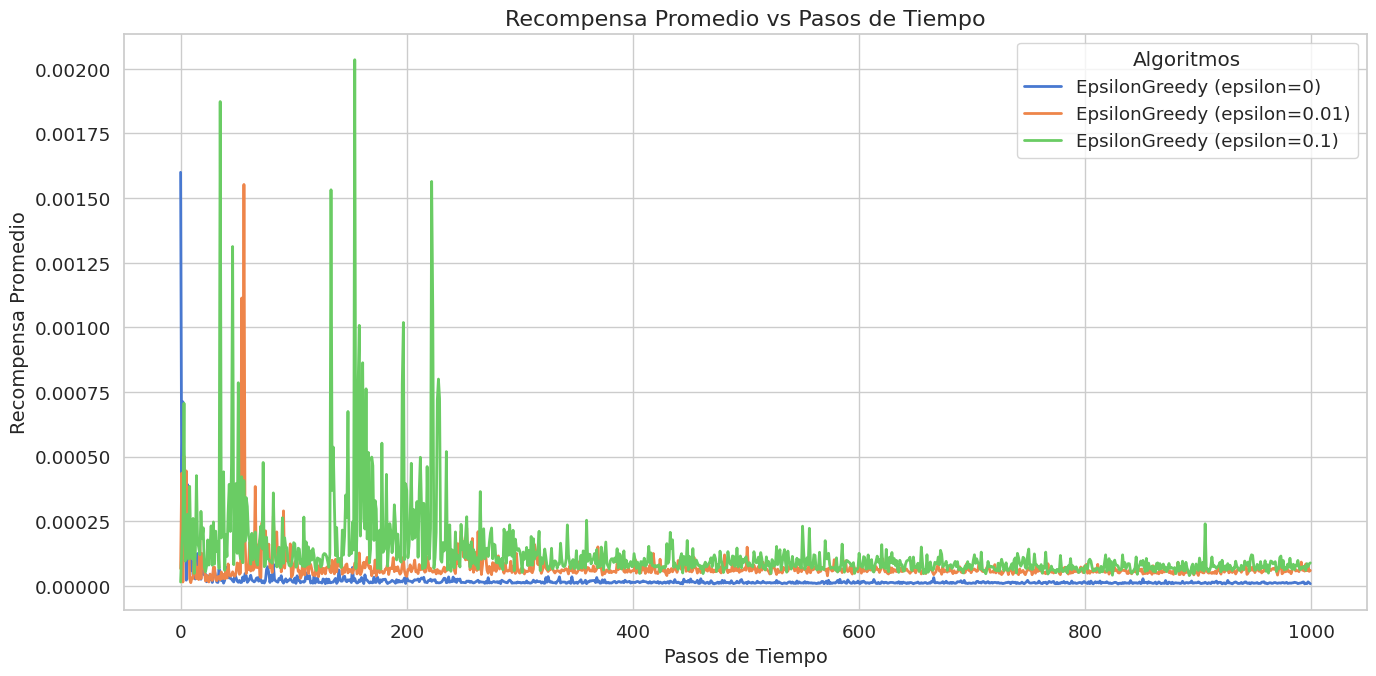

In [ ]:
plot_average_rewards(steps, rewards, algorithms)

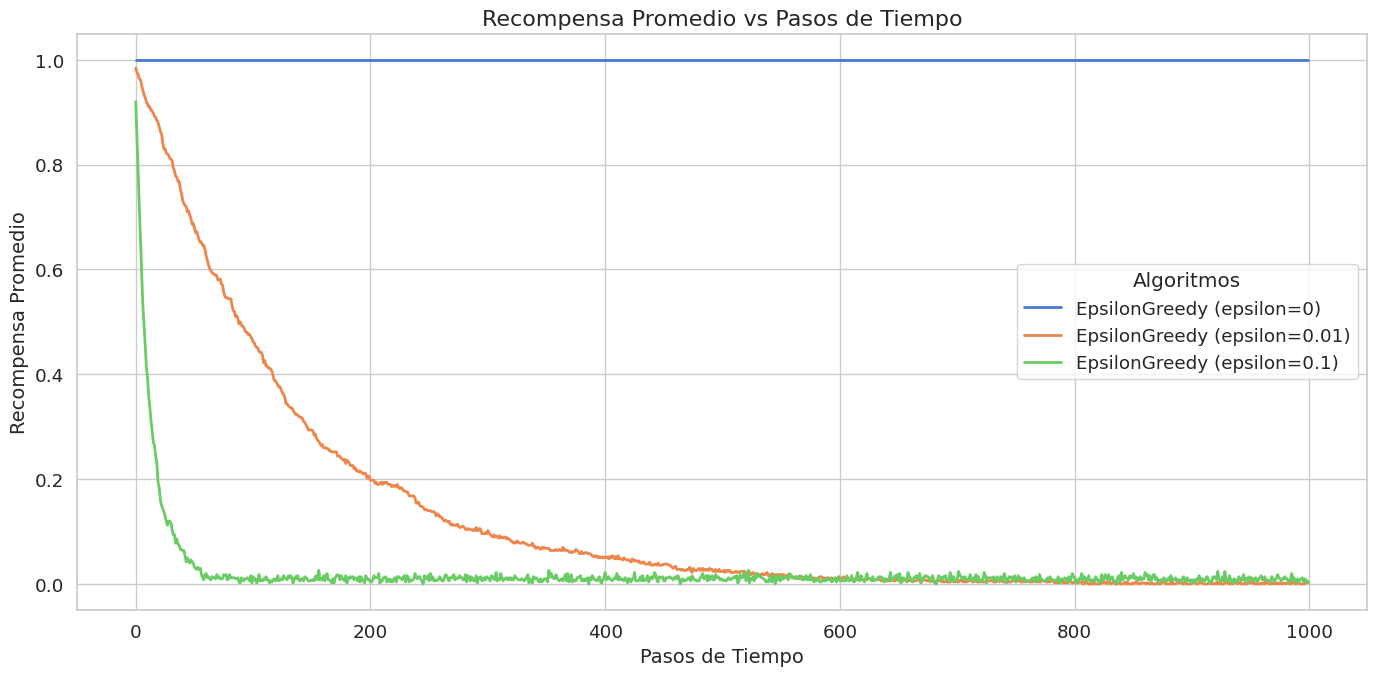

In [ ]:
plot_optimal_selections(steps, optimal_selections, algorithms)

/content/eml_k_bandit/plotting/plotting.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=45, ha="right", fontsize=10)


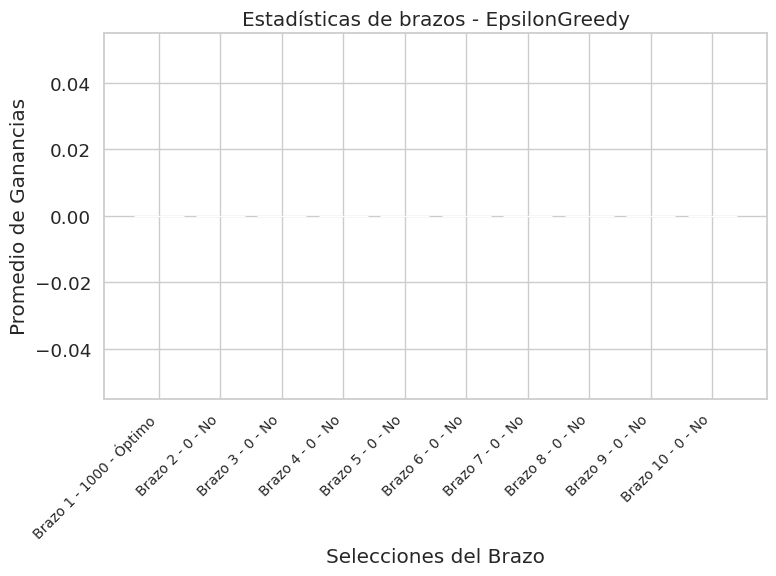

/content/eml_k_bandit/plotting/plotting.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=45, ha="right", fontsize=10)


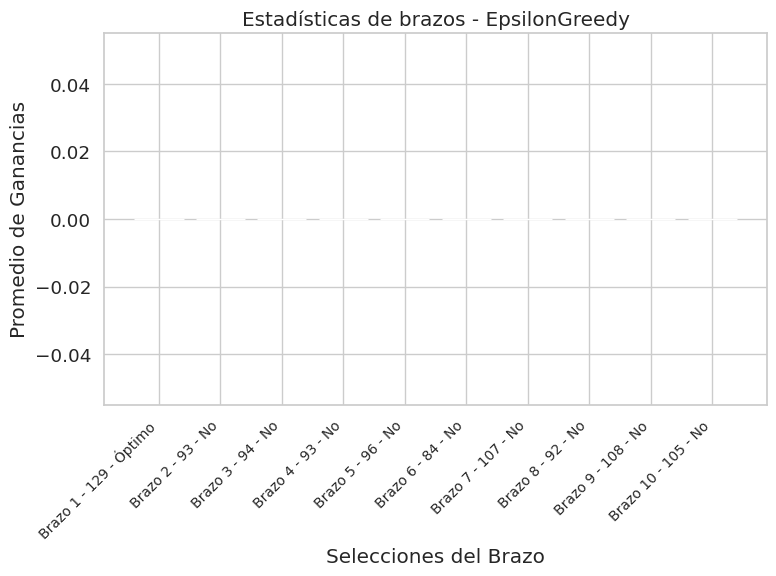

/content/eml_k_bandit/plotting/plotting.py:123: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels, rotation=45, ha="right", fontsize=10)


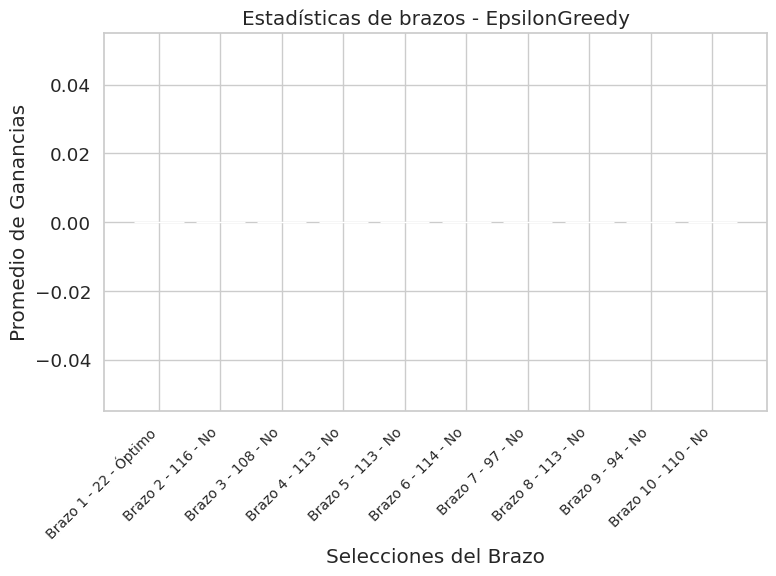

In [ ]:
plot_arm_statistics(arm_stats, algorithms)

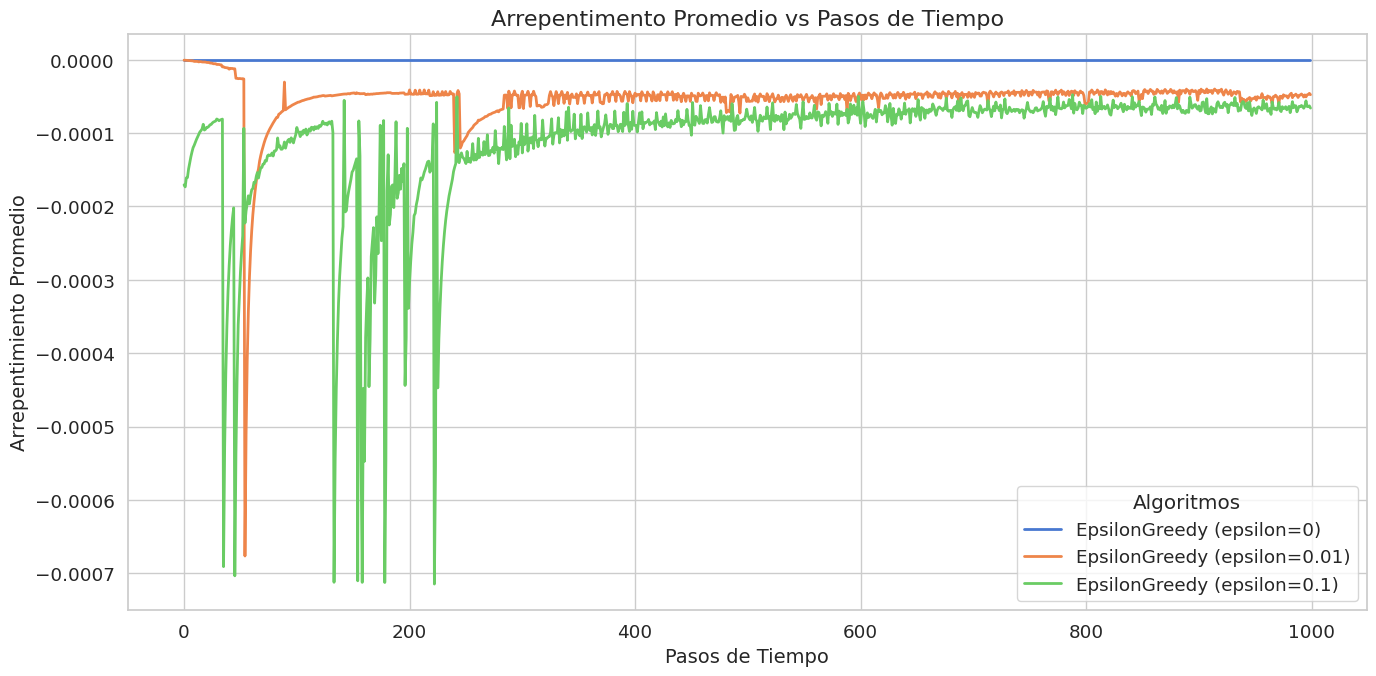

In [ ]:
plot_regret(steps, regret_accumulated, algorithms)

In [ ]:
import shutil

# Especifica el nombre de la carpeta que quieres convertir en ZIP
folder_path = "/content/eml_k_bandit"  # Ruta de la carpeta que deseas comprimir

# Especifica el nombre y la ubicación del archivo ZIP
zip_path = "/content/eml_k_bandit.zip"

# Crear el archivo ZIP
shutil.make_archive(zip_path.replace('.zip', ''), 'zip', folder_path)

print(f"Carpeta comprimida como {zip_path}")


Carpeta comprimida como /content/eml_k_bandit.zip
